# Classification Problem
In this notebook we work on classification of [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). We define some notation to use later on

* $x^{(i)}$ are input-images each has shape 32x32x3 (RGB)
* $y^{(i)}$ are labels of above images and can take values $0,\ldots,9$ corresponding to 10 classes

To solve this classification, we try to find a function $h$ that maps from image $x$ to scores i.e
$$
h: x \mapsto \left(\begin{array}{c}s_0(x)\\ \ldots\\ s_9(x)\end{array}\right)
$$
where $s_i(x)$ is score of $x$ in $i-$th class. Then we predict the label of $x$ as
$$
x\text{'s label}:=\mathrm{arg}\max_{i}s_i(x)
$$

The notebook is organized as follows
* Load CIFAR-10 dataset 
* Introduce Linear classifier
* Pre-processing data for Linear classifier
* Multiclass SVM loss
* Optimize SVM loss with SGD

The goal of this notebook is to learn how to implement SVM loss function in [numpy](http://www.numpy.org/) and [TensorFlows](https://www.tensorflow.org/).

Let's start by loading some python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# append common path
import sys
COMMON_PATH = '../common'
if COMMON_PATH not in sys.path:
    sys.path.insert(0, COMMON_PATH)
    
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


# Get the data
We need to download dataset from the internet and untar it, we use some helper functions in *common* directory

In [2]:
from data_utils import download_file_to_cwd, untar_to_cwd

url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'

# download data to current directory
download_file_to_cwd(url, filename)

# untar the data
cifar10_dir = 'cifar-10-batches-py'
untar_to_cwd(filename, cifar10_dir)

http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz is downloaded to ./cifar-10-python.tar.gz
./cifar-10-python.tar.gz is untar to ./cifar-10-batches-py


In [3]:
# load data to memory
from cifar10_input import load_CIFAR10

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# let's divide train into training set (49000) + validation set (1000)
num_training = 49000

mask = range(num_training, X_train.shape[0])
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

print ('Train inputs shape: {}'.format(X_train.shape))
print ('Train labels shape: {}'.format(y_train.shape))

print ('Validation inputs shape: {}'.format(X_val.shape))
print ('Validation labels shape: {}'.format(y_val.shape))

print ('Test inputs shape: {}'.format(X_test.shape))
print ('Test labels shape: {}'.format(y_test.shape))


Train inputs shape: (49000, 32, 32, 3)
Train labels shape: (49000,)
Validation inputs shape: (1000, 32, 32, 3)
Validation labels shape: (1000,)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


# Linear classifier
We consider $h(x)$ as linear function of $x$
$$
h(x) = f(x,W) = w_0 + \sum_{i,j}w_{i,j}x_{i,j}
$$

Our goal is to find $W$ to minimize some loss function 
$$
L(y, f(x, W))
$$
where $y$ is the label of the image $x$.

## Pre-processing training data
To simplify our computation, we do the following preprocesing steps

* flatten our input image 32x32x3 => 3072 
* normalize training data (it's always good idea to have normalized input with mean = 0.0), 
* append one (for bias term) to the end of each input.

In [4]:
# flatten input data
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

# normalize training data
mean_images = np.mean(X_train, axis=0)
X_train -= mean_images
X_val -= mean_images
X_test -= mean_images

# append one for bias term
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print ('Train inputs shape: {}'.format(X_train.shape))
print ('Validation inputs shape: {}'.format(X_val.shape))
print ('Test inputs shape: {}'.format(X_test.shape))

Train inputs shape: (49000, 3073)
Validation inputs shape: (1000, 3073)
Test inputs shape: (10000, 3073)


In the above code, $x$ is flattened $x\in\mathbb{R}^D$ (D=3073 in our example) and we consider the input data in following form
$$
X = \left(\begin{array}{c}
(x^{(1)})^T\\
\vdots\\
(x^{(N)})^T
\end{array}\right)\in \mathbb{R}^{N\times D}
$$
so the weight matrix $W$ has shape $D\times C$ with $C$ is number of classes (in our example $C=10$) and our linear function is given by
$$
f(X,W) = X\times W
$$
where each row is score for each input.

## Multiclass SVM loss
Given $(x,y)$ are the image and the label,respectively, and the scores $s(x)=f(x,W)$, the SVM loss for one sample $(x,y)$ has the form
$$
L(y, s(x)) = \sum_{i\neq y}\max(0, s_i - s_y + 1)
$$
Intutively, if $s_y >= s_i + 1$ for all $i\neq y$ we then have SVM loss $=0$, so the SVM is try to maximize the chance of $s_y$ is the maximum of $s_i$. Since we predict the label of $x$ as $\mathrm{arg}\max_{i}s_i$, minimize SVM loss might help to maximize correct prediction.

The SVM loss for $N$ samples is the mean of SVM loss at each one sample plus a regulized form:
$$
\mathrm{loss}(W) = \frac{1}{N} \sum_{i=1}^NL\left(y^{(i)}, s(x^{(i)})\right) + \frac{1}{2}\lambda ||W||^2
$$
where $||W||^2 = \sum_{i,j}W_{i,j}^2$ is added to reduce overfitting

In the following we implement the SVM loss 
* using **numpy** only
* using **TensorFlow**

Note that we need to compute not only the loss function but also the gradient with respect to $W$ so that we can use with SGD to minimize the loss. 

Let's compute the loss, we define $M = \left(M_{ij}\right)\in \mathbb{R}^{N\times D}$ where
$$
 M_{ij} = \left\{ \begin{array}{l}
 s_j\left(x^{(i)}\right) - s_{y^{(i)}}\left(x^{(i)}\right) + 1 \text{ for } j\neq y^{(i)}\\
 0 \text{ otherwise}
 \end{array}
 \right.
$$
Then the SVM-loss is given as
$$
 \sum_{i=1}^NL\left(y^{(i)}, s(x^{(i)})\right) = \sum_{ij}M_{ij}\times 1_{M_{ij} > 0}
$$

Let's derive the gradient, we have
$$
 \frac{\partial}{\partial W_{uv}} \max\left(0, s_j\left(x^{(i)}\right) - s_{y^{(i)}}\left(x^{(i)}\right) + 1\right)  = 1_{M_{ij} > 0}\times \left(x^{(i)}_{u}\times 1_{j=v} -x^{(i)}_{u}\times 1_{j=y^{(i)}}\right)
$$
so the we have
$$
\nabla_W\max\left(0, s_j\left(x^{(i)}\right) - s_{y^{(i)}}\left(x^{(i)}\right) + 1\right) =  1_{M_{ij} > 0} \times \left(\begin{array}{ccccccccccc}
    0 & \cdots & 0 &x^{(i)}_1 & 0 & \cdots & 0 & -x^{(i)}_1 & 0 & \cdots & 0\\
    0 & \cdots & 0 &x^{(i)}_2 & 0 & \cdots & 0 & -x^{(i)}_2 & 0 & \cdots & 0\\
    \vdots & \vdots & \vdots& \vdots& \vdots& \vdots& \vdots& \vdots& \vdots& \vdots& \vdots\\
    0 & \cdots & 0 & \smash[b]{\underbrace{x^{(i)}_D}_{j-th}} & 0 & \cdots & 0 & \smash[b]{\underbrace{-x^{(i)}_D}_{y^{(i)}-th}} & 0 & \cdots & 0
\end{array}\right)
$$

Denote $P=(P_{ij})\in \mathbb{R}^{N\times D}$ is defined as
$$
P_{ij} = \left\{\begin{array}{ll}
1_{M_{ij} > 0} & \text{if } j\neq y^{(i)}\\
- \sum_{j\neq y^{(i)}} 1_{M_{ij} > 0} & \text{otherwise}
\end{array}
\right.
$$
From above equation, we can show that
$$
\nabla_W L\left(y^{(i)}, s(x^{(i)})\right) = P[i] \times x^{(i)}
$$
where $P[i]$ is i-th row of $P$, so
$$
\nabla_W\sum_{i=1}^NL\left(y^{(i)}, s(x^{(i)})\right) = \sum_{i=1}^N P[i] \times x^{(i)} = X^T\times P
$$

### Implentation SVM with Numpy

In [5]:
def svm_np(W, X, y, reg):
    '''
    we implement svm loss defined as above
        X: data inputs has shape (N, D)
        y: labels has shape (N,)
        W: weights has shape (D, num_classes)
        reg: positive real number
    the function return
        loss: svm loss
        dW: gradient of loss regarding to W
    '''    
    scores = X.dot(W)    # N x num_classes
    
    if y is None:
        return scores
    
    N = X.shape[0]
    M = 1 + scores - scores[range(N), y].reshape(N,1)    
    M[range(N), y] = 0.0
    
    pos_scores = np.zeros_like(M)
    pos_scores[M > 0] = 1.0
    
    # svm loss
    loss = np.sum(M * pos_scores) / N
    
    # adding reg
    loss += 0.5 * reg * np.sum(W*W)
    
    # implement the grad
    sum_pos_scores = np.sum(pos_scores, axis=1)  # sum 1_{M_{ij} > 0}
    pos_scores[range(N), y] = - sum_pos_scores
    
    # grad SVM with respect to W
    dW = X.T.dot(pos_scores) / N
    
    # grad L2 reg with respect to W
    dW += reg * W
    
    return loss, dW
    

In [6]:
# we do some test on the loss function & grad
X_dev = X_train[:100]
y_dev = y_train[:100]

D = X_train.shape[1]  # 3073
num_classes = 10
# test the loss with W initialized very small
W = np.random.randn(D, num_classes) * 1.0e-5

loss,_ = svm_np(W, X_dev, y_dev, 1e-5)
print ('loss for weight close to zero: {:.4f}, we should expect loss is close to 9'.format(loss))

loss for weight close to zero: 8.9786, we should expect loss is close to 9


In [7]:
# test the grad vs numerical grad
from gradient_check import grad_check_sparse, rel_error

# first test with 
reg = 0.0
print ('\ntest analytics grad vs numerical grad for reg={:.2f}'.format(reg))
loss_t1, dW_t1 = svm_np(W, X_dev, y_dev, reg)
print ('loss: {:10.4f}'.format(loss_t1))
f = lambda w: svm_np(w, X_dev, y_dev, reg)[0]
grad_num = grad_check_sparse(f, W, dW_t1)

reg = 1.0e5
print ('\ntest analytics grad vs numerical grad for reg={:.2f}'.format(reg))
loss_t2, dW_t2 = svm_np(W, X_dev, y_dev, reg)
print ('loss: {:10.4f}'.format(loss_t2))
f = lambda w: svm_np(w, X_dev, y_dev, reg)[0]
grad_num = grad_check_sparse(f, W, dW_t2)


test analytics grad vs numerical grad for reg=0.00
loss:     8.9786
numerical:      -7.12 analytic:      -7.12, relative error: 2.32209e-12
numerical:     -20.58 analytic:     -20.58, relative error: 7.89882e-14
numerical:      29.44 analytic:      29.44, relative error: 2.94582e-13
numerical:      18.87 analytic:      18.87, relative error: 1.40428e-12
numerical:     -11.73 analytic:     -11.73, relative error: 2.12009e-12
numerical:      13.95 analytic:      13.95, relative error: 7.35565e-13
numerical:      32.50 analytic:      32.50, relative error: 1.02084e-12
numerical:       2.01 analytic:       2.01, relative error: 1.59684e-11
numerical:      57.43 analytic:      57.43, relative error: 4.55323e-13
numerical:       5.17 analytic:       5.17, relative error: 5.76042e-12

test analytics grad vs numerical grad for reg=100000.00
loss:     9.1337
numerical:     -18.45 analytic:     -18.45, relative error: 9.26696e-13
numerical:       2.98 analytic:       2.98, relative error: 1.279

Looking at numerical gradient v.s analytics one, we are confident about our implementation. Let's try to re-implement in in TensorFlow

### Implentation SVM with TensorFlow
The main difficulty with TensorFlow is it does not support dynamics range i.e given $M$ is a 2D-tensor and we can't access $M[0:N-1,y]$ where $N$ is number of input. However, there is a work around, by fixing the batch_size $N$, we create a range $[0:N-1]$ in advance, then we can access $M[0:N,y]$. 

The implementation is given below, and we test v.s numpy implementation:

In [8]:
#tf.reset_default_graph()

def svm_tf(W, X, y,  reg, batch_idx):    
    scores = tf.matmul(X, W)
    
    coord = tf.transpose(tf.stack([batch_idx, y]))    
    correct_scores = tf.gather_nd(scores, coord)    
    M = tf.nn.relu(1.0 + scores - tf.reshape(correct_scores,[-1,1]))
    cost = tf.reduce_mean(tf.reduce_sum(M, axis=1)) - 1.0 + reg * tf.nn.l2_loss(W)
    grad = tf.gradients(cost, [W])[0]
    correct_pred = tf.equal(tf.argmax(scores, axis = 1), y)
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return cost, grad, acc

batch_size = 100
X_dev = X_train[:batch_size]
y_dev = y_train[:batch_size]
batch_idx = tf.constant(np.arange(batch_size))
vX = tf.placeholder(tf.float64, [None, D])
vy = tf.placeholder(tf.int64, [None])
vreg = tf.placeholder(tf.float64)
vW = tf.Variable(W, name = 'W')

cost, grad, _ = svm_tf(vW, vX, vy, vreg, batch_idx)

reg = 0.0
print ('\ntest analytics grad vs numerical grad for reg={:.2f}'.format(reg))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss, dW = sess.run([cost, grad], feed_dict = {vX : X_dev, vy : y_dev, vreg : reg})
    print('loss is: {:.4f} rel error: {:10.5e}'.format(loss, rel_error(loss, loss_t1)))
    print('grad rel error: {:10.5e}'.format(rel_error(dW, dW_t1)))

reg = 1.0e5
print ('\ntest analytics grad vs numerical grad for reg={:.2f}'.format(reg))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss, dW = sess.run([cost, grad], feed_dict = {vX : X_dev, vy : y_dev, vreg : reg})
    print('loss is: {:.4f} rel error: {:10.5e}'.format(loss, rel_error(loss, loss_t2)))
    print('grad rel error: {:10.5e}'.format(rel_error(dW, dW_t2)))    


test analytics grad vs numerical grad for reg=0.00
loss is: 8.9786 rel error: 9.89213e-17
grad rel error: 5.33548e-11

test analytics grad vs numerical grad for reg=100000.00
loss is: 9.1337 rel error: 9.72417e-17
grad rel error: 3.82242e-12


The TensorFlow and Numpy both give very similar results. Let's try to optimize it using SGD, (we will scale down the datatype float64 -> float32 to reduce memory consumption), first we do it with numpy

## Optimize with SGD algorithm

### Implement SGD with Numpy
We start by implementing SGD in numpy. To simplify our task, we use the Dataset from data_utils to get batch-input

In [9]:
def sgd_np(f, initW, train_data, val_data, reg, epochs, learning_rate = 1.0e-3, print_every = 20):
    '''
    sgd_np implements SGD algorithm to minimize function f
        f: is a function with signature f(X, y, W, reg) => loss, grad
        initW: is initial weights
        train_data: is Dataset object supports function next_batch() => X_batch, y_batch used in train-step
        val_data: is Dataset object supports function next_batch() => X_batch, y_batch used in val-step
        reg: regularization lambda
        learning_rate: a hyperparameter to control update-step W:= W - learning_rate * dW        
        print_every: log to console the loss & store it in loss_history to visualize it laters
    '''   
    
    # downcast to float32
    W = initW.astype(np.float32)
    
    # get number of iteration
    nb_iters = train_data.get_nb_iters(epochs)
    loss_history = []
    
    start = time.time()
    for i in range(1, nb_iters + 1):
        X_batch, y_batch = train_data.next_batch()
        loss, grad = f(W, X_batch, y_batch, reg)  
        loss_history.append(loss)
        
        it_per_second = i / (time.time() - start)
        #sys.stdout.write("\rProgress: {:>5.2f}% Speed (it/sec): {:>10.4f}".format(100 * i / nb_iters, it_per_second))
                       
        # sgd update for minimize loss
        W -= learning_rate * grad        
        
        # log current state        
        if (i % print_every == 0):        
            print('Iter {:>10d}/{:<10d} loss {:10.4f}'.format(i, nb_iters, loss))
        
        
        epoch_end, epoch = train_data.is_epoch_end(i)
        if (epoch_end) or (i == 1):
            # validation it here
            if val_data is not None:
                X_val, y_val = val_data.next_batch()
                scores = f(W, X_val, None, reg)
                acc = np.mean(np.argmax(scores, axis=1) == y_val)
                print('\nEpoch {:>3d}/{:<3d} val_acc = {:5.2f}%'.format(epoch, epochs, 100 * acc))
    
    print ('\nTrain time: {:<10.2f} seconds'.format(time.time() - start))
    return W, loss_history

### Fit optimal weight with SGD
We now are ready to fit optimal weight for SVM, we should expect accuracy ~ 37%

In [10]:
from data_utils import Dataset
D = X_train.shape[1]
initW = 0.001 * np.random.randn(D,10) 

lr = 1e-7
reg = 5e4
epochs = 10
batch_size = 200

train_data = Dataset(X_train, y_train, batch_size, dtype = np.float32)
val_data = Dataset(X_val, y_val, 1000, dtype = np.float32)

np.random.seed(2793)

W, loss_hist = sgd_np(svm_np, initW, train_data, val_data, reg, epochs, 
                      learning_rate=lr, print_every=100)


Epoch   0/10  val_acc = 12.40%
Iter        100/2450       loss   293.4844
Iter        200/2450       loss   110.6457

Epoch   1/10  val_acc = 31.50%
Iter        300/2450       loss    43.6644
Iter        400/2450       loss    19.4370

Epoch   2/10  val_acc = 36.70%
Iter        500/2450       loss    10.2672
Iter        600/2450       loss     6.9989
Iter        700/2450       loss     6.4587

Epoch   3/10  val_acc = 37.10%
Iter        800/2450       loss     5.1771
Iter        900/2450       loss     5.5268

Epoch   4/10  val_acc = 37.90%
Iter       1000/2450       loss     4.7950
Iter       1100/2450       loss     5.0537
Iter       1200/2450       loss     5.5000

Epoch   5/10  val_acc = 37.40%
Iter       1300/2450       loss     5.1793
Iter       1400/2450       loss     5.4389

Epoch   6/10  val_acc = 38.50%
Iter       1500/2450       loss     5.3384
Iter       1600/2450       loss     5.2760
Iter       1700/2450       loss     5.4559

Epoch   7/10  val_acc = 39.30%
Iter       18

### Test obtained weights on test data
We can test our obtimal weight on X_test, y_test

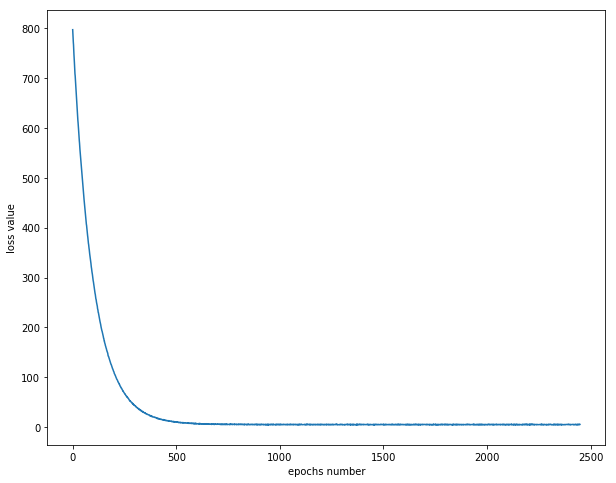


Valuation on test-set acc = 35.94%


In [11]:
plt.plot(loss_hist)
plt.xlabel('epochs number')
plt.ylabel('loss value')
plt.show()

scores = svm_np(W, X_test, None, reg)
acc = np.mean(np.argmax(scores, axis=1) == y_test)
print('\nValuation on test-set acc = {:5.2f}%'.format(100 * acc))

### SGD with TensorFlow
Now, let's try SGD with TensorFlow which is very convenient since SGD is already implemented in SGD: [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)

In [12]:
def sgd_tf(initW, train_data, val_data, reg, epochs, learning_rate = 1.0e-3, print_every = 20):
    # setup input
    train_idx = tf.constant(np.arange(train_data.batch_size()))
    val_idx = tf.constant(np.arange(val_data.batch_size()))
    vX = tf.placeholder(tf.float32, [None, D])
    vy = tf.placeholder(tf.int64, [None])
    vreg = tf.placeholder(tf.float32)
    
    # trainable variable
    vW = tf.Variable(initW.astype(np.float32), name = 'W')
    
    # cost & acc
    cost, _, _ = svm_tf(vW, vX, vy, vreg, train_idx)
    _, _, val_acc = svm_tf(vW, vX, vy, vreg, val_idx)
    
    # setup optimizer
    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    nb_iters = train_data.get_nb_iters(epochs)
    loss_history = []    
    opt_W = None
    with tf.Session() as sess:
        # init out variable
        sess.run(tf.global_variables_initializer())
        
        # training loop
        start = time.time()
        for i in range(1, nb_iters + 1):
            X_batch, y_batch = train_data.next_batch()
            loss, _ = sess.run([cost, train_op], feed_dict= {vX : X_batch,
                                                             vy : y_batch,
                                                             vreg : reg})
            
            loss_history.append(loss)
            # log current state        
            if (i % print_every == 0):                    
                print('Iter {:>10d}/{:<10d} loss {:10.4f}'.format(i, nb_iters, loss))


            epoch_end, epoch = train_data.is_epoch_end(i)
            if (epoch_end) or (i == 1):
                # validation it here
                if val_data is not None:
                    X_val, y_val = val_data.next_batch()
                    
                    acc = sess.run(val_acc, feed_dict= { vX : X_val,
                                                         vy : y_val,
                                                         vreg : reg})
                    
                    print('\nEpoch {:>3d}/{:<3d} val_acc = {:5.2f}%'.format(epoch, epochs, 100 * acc))
        
        print ('\nTrain time: {:<10.2f} seconds'.format(time.time() - start))
        
        opt_W = sess.run(vW)
    return opt_W, loss_history

In [13]:
# test TensorFlow's SGD
lr = 1e-7
reg = 5e4
epochs = 10
batch_size = 200

train_data = Dataset(X_train, y_train, batch_size, dtype = np.float32)
val_data = Dataset(X_val, y_val, 1000, dtype = np.float32)

np.random.seed(2793)

W_tf, loss_hist_tf = sgd_tf(initW, train_data, val_data, reg, epochs, 
                      learning_rate=lr, print_every=100)
    


Epoch   0/10  val_acc = 12.40%
Iter        100/2450       loss   293.4841
Iter        200/2450       loss   110.6457

Epoch   1/10  val_acc = 31.50%
Iter        300/2450       loss    43.6644
Iter        400/2450       loss    19.4370

Epoch   2/10  val_acc = 36.70%
Iter        500/2450       loss    10.2672
Iter        600/2450       loss     6.9989
Iter        700/2450       loss     6.4587

Epoch   3/10  val_acc = 37.10%
Iter        800/2450       loss     5.1771
Iter        900/2450       loss     5.5268

Epoch   4/10  val_acc = 37.90%
Iter       1000/2450       loss     4.7950
Iter       1100/2450       loss     5.0537
Iter       1200/2450       loss     5.5000

Epoch   5/10  val_acc = 37.40%
Iter       1300/2450       loss     5.1793
Iter       1400/2450       loss     5.4389

Epoch   6/10  val_acc = 38.50%
Iter       1500/2450       loss     5.3384
Iter       1600/2450       loss     5.2760
Iter       1700/2450       loss     5.4559

Epoch   7/10  val_acc = 39.30%
Iter       18

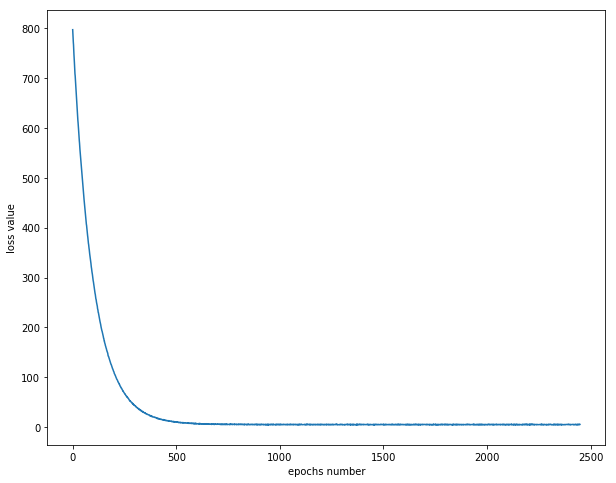


Valuation on test-set acc = 35.94%


In [14]:
plt.plot(loss_hist_tf)
plt.xlabel('epochs number')
plt.ylabel('loss value')
plt.show()

scores = svm_np(W_tf, X_test, None, reg)
acc = np.mean(np.argmax(scores, axis=1) == y_test)
print('\nValuation on test-set acc = {:5.2f}%'.format(100 * acc))
  

# Conclusion
We have implemented Multiclass SVM Linear Classifier using Numpy and TensorFlow, they both give similar result. However due to the difficulty while accessing array's index it seems that TensorFlows is 3 times slower than Numpy. Notice that the svm loss function is  implemented by us so it might not as optimal as it should be. We hope TensorFlow will improve array indexing in the next release and also implement more loss function (they seem only implement softmax).